In [1]:
%matplotlib inline
import os, sys
import csv
import torch
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


from Analysis_Utils import *

import warnings
warnings.filterwarnings('ignore')

### Load All Models

In [2]:
#############################  Conv Net #######################################
Cnet = torch.load('Cnet_Kaggle.pth').eval()



#############################  LSTM #######################################
lstm = torch.load('this_morning_w_do.pth').eval()



############################## Seq2Seq ####################################
seq2seq = torch.load('seq_seq_model_sinlgle_char_50_mutation.pt')

encoder_dict = seq2seq['encoder_model']
encoder = EncoderLSTM(vocab_size,hidden_size)
encoder.load_state_dict(encoder_dict)
encoder = encoder.cuda().eval()

decoder_dict = seq2seq['decoder_model']
decoder = DecoderLSTM(hidden_size, vocab_size)
decoder.load_state_dict(decoder_dict)
decoder = decoder.cuda().eval()



#############################  CLSTM #######################################
clstm = torch.load('CLSTM_3P.pth').eval()


### Load Test Data

The test data is generated by taking 200 true (or correct) words and fetching 100 image-sequences for each word. Each sequence consists of images randomly sampled from the test set of Sign Language MNIST. Sample sequences are shown below.

In [3]:
PATH = '../Data/Image_Data_Original/'

print("loading data...")

test_images = csv2images(PATH+'sign_mnist_test.csv')
testWordstestImages = torch.load(PATH+'testWordstestImages.pt')   #### this data should be common for all evaluations

num_of_img_sequences_per_word = 100 ### approximately

test_data_size = 200 * num_of_img_sequences_per_word

data, labels = get_data(testWordstestImages, test_images, test_data_size)
print("done")

print("number of data sample: ", len(data), '\n')

get_unique_words(labels, test_data_size)   ##### there are multiple image sequences per word, 
                                            #### let's see how many unique words we have

loading data...
done
number of data sample:  20000 

No. of Unique Words:  199 



Let's check various sequences for the first word

abberant


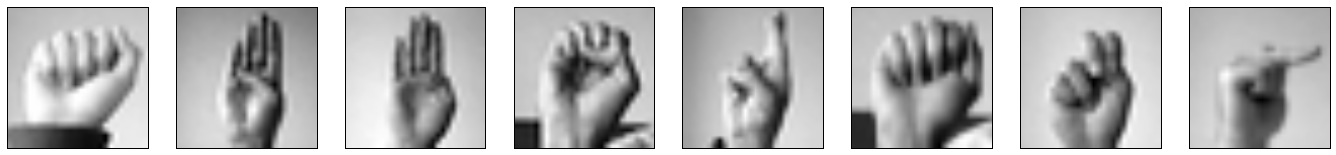

abberant


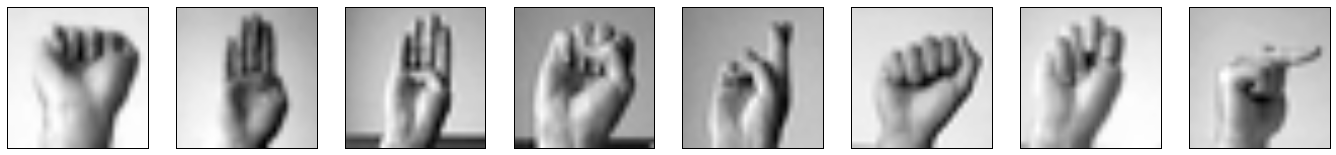

abberant


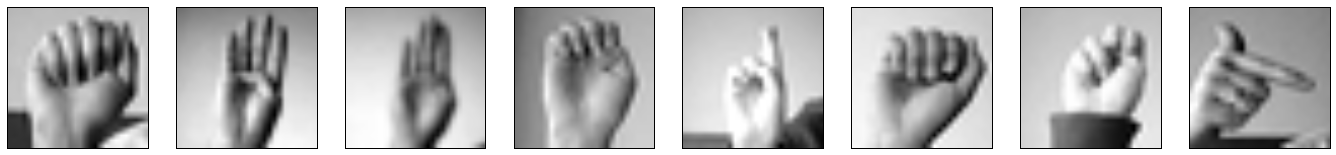

In [42]:
indices = list(range(3))

for idx in indices:
    print(testWordstestImages[idx][0])

    fig = plt.figure(figsize = (60,50))
    for j in range(len(data[idx])):
        plt.subplot(1, 20, j+1)
        im = plt.imshow(data[idx][j], cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

### Evaluation and Comparison

Now, we use the test data obtained above as input to various models and check their performances...

In [5]:
model_names = ['' for x in range(6)]
pred_errors = [0 for x in range(6)]
pred_mismatches = [[] for x in range(6)]
postproc_stats = [[] for x in range(6)]

### Model 1: Baseline CNN

The baseline for performance of all models is set by a Convolutional Network without any property of recurrence. For this model, an input sequence is fed image-by-image into the trained CNN and the output alphabets are joined together into a string.

In [6]:
mdl = 0
CNN_spellings,  mismatch_cnt, err = BasicCNN_evaluation(data, labels, Cnet)

model_names[mdl] = 'CNN Solo'
pred_errors[mdl] = err
pred_mismatches[mdl] = mismatch_cnt
postproc_stats[mdl] = []

### Model 2: LSTM Post-Processing over CNN

In [7]:
mdl = 1
LSTMoverCNN_spellings,  mismatch_cnt, err, in_out_stats = LSTM_PostProc_evaluation(CNN_spellings, labels, lstm)

model_names[mdl] = 'LSTM Post-proc over CNN'
pred_errors[mdl] = err
pred_mismatches[mdl] = mismatch_cnt
postproc_stats[mdl] = in_out_stats

### Model 3: Sequence-to-Sequence Post-Processing over CNN

In [8]:
mdl = 2
Seq2SeqOverCNN_spellings, mismatch_cnt, err, in_out_stats = Seq2Seq_PostProc_evaluation(CNN_spellings, labels, 
                                                                                                       encoder, decoder)

model_names[mdl] = 'Seq2Seq Post-proc over CNN'
pred_errors[mdl] = err
pred_mismatches[mdl] = mismatch_cnt
postproc_stats[mdl] = in_out_stats

### Model 4: End-to-End Convolutional LSTM (CLSTM)  

In [9]:
mdl = 3
CLSTM_spellings,  mismatch_cnt, err = CLSTM_evaluation(data, labels, clstm)

model_names[mdl] = 'End-to-End CLSTM'
pred_errors[mdl] = err
pred_mismatches[mdl] = mismatch_cnt
postproc_stats[mdl] = []

### Model 5: LSTM Post-Processing over CLSTM  

In [10]:
mdl = 4
LSTMoverCLSTM_spellings,  mismatch_cnt, err, in_out_stats = LSTM_PostProc_evaluation(CLSTM_spellings, labels, lstm)

model_names[mdl] = 'LSTM Post-proc over CLSTM'
pred_errors[mdl] = err
pred_mismatches[mdl] = mismatch_cnt
postproc_stats[mdl] = in_out_stats

### Model 6: Sequence-to-Sequence Post-Processing over CLSTM  

In [11]:
mdl = 5
Seq2SeqOverCLSTM_spellings,mismatch_cnt,err,in_out_stats = Seq2Seq_PostProc_evaluation(CLSTM_spellings, labels, encoder, decoder)

model_names[mdl] = 'Seq2Seq Post-proc over CLSTM'
pred_errors[mdl] = err
pred_mismatches[mdl] = mismatch_cnt
postproc_stats[mdl] = in_out_stats

## Accuracy

This measure is based on word-level prediction accuracy. If the predicted word matches the target word, it is treated as 1 positive instance of prediction. If the predicted word does not match target word by one or more alphabets, it is treated as 1 instance of negative prediction. In the plots below, we show the percentages of correct and incorrect predictions for various models.

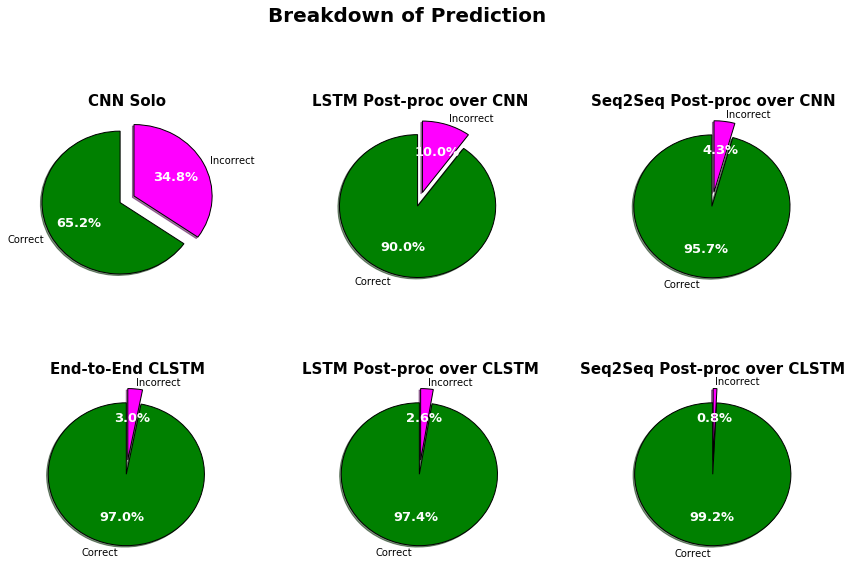

In [12]:
plot_prediction_pie(pred_errors, model_names)

# Explain Accuracy!

## Mismatch between Predicted Word and True Word

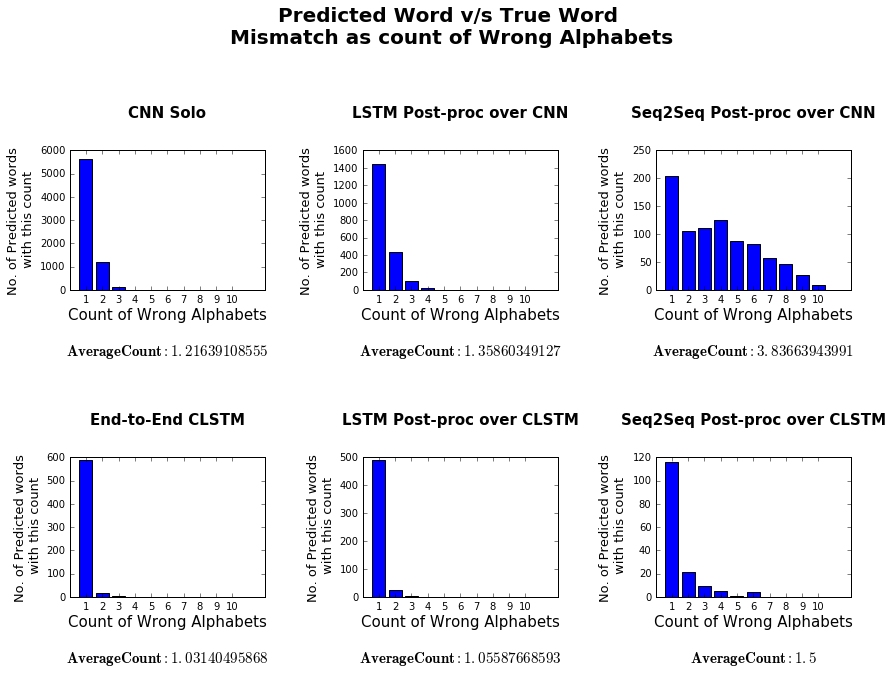

In [13]:
plot_word_mismatch(pred_mismatches, model_names)

Although Sequence-to-Sequence word corrector model enhances overall accuracy significantly, it also produces incorrect 
words with more wrong alphabets. This may increase the difference between true word and predicted word perceived by
a user oblivious to workings of the predictor model. In simple terms, it may be easier for a user to faithfuly edit (into
true word) an incorrect prediction with 1 wrong alphabet than an incorrect prediction with, say, 6 wrong aplhabets. 

## Effect of Post-processing on the Outputs of CNN

The LSTM and Sequence-to-Sequence models essentially perform a text correcting post-processing over the outputs of gesture
recognition models. In the previous sections, we analyzed the performance of post-processing in terms of overall accuracy 
and (mis)match with true target words. Here, we will analyze the performance of post-processing with respect to the intermediate
inputs which are the ouputs from CNN. In the next section, we will do the same analysis for ouputs of CLSTM as inputs to post-
processor.

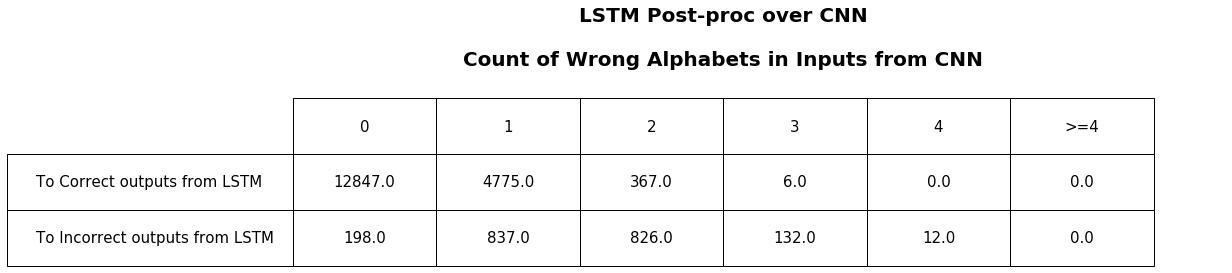

In [14]:
plot_post_processor_stats(postproc_stats[1], model_name=model_names[1])

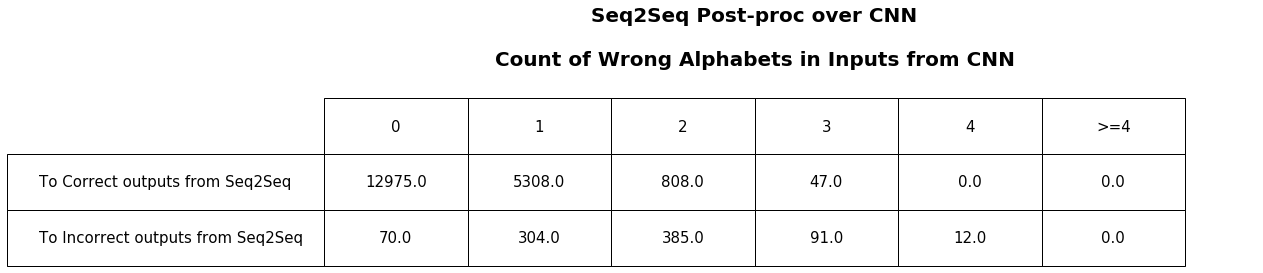

In [15]:
plot_post_processor_stats(postproc_stats[2], model_name=model_names[2])

One key observation here is that the Seq2Seq model is capable of correcting more inputs with 2 or more wrong alphabets, as
compared to simple LSTM. For e.g., in columns 3, Seq2Seq has an incorrect/correct distribution of 54.0/91.0 while LSTM has an almost reversed distriubtion of 94.0/51.0. 

It's worthwhile to note here that both LSTM and Seq2Seq models are trained on words with single alphabet mistake. Yet, 
Seq2Seq seems to generalize better to words with multiple aphabets mistakes.

## Effect of Post-processing on the Outputs of CLSTM

This is simply a cherry-on-the-top analysis! 

Although CLSTM works quite well as Gesture Recognizer in terms of accuracy, the LSTM and Seq2Seq models can still be applied as post-processors due to being decoupled from gesture recognizer model.

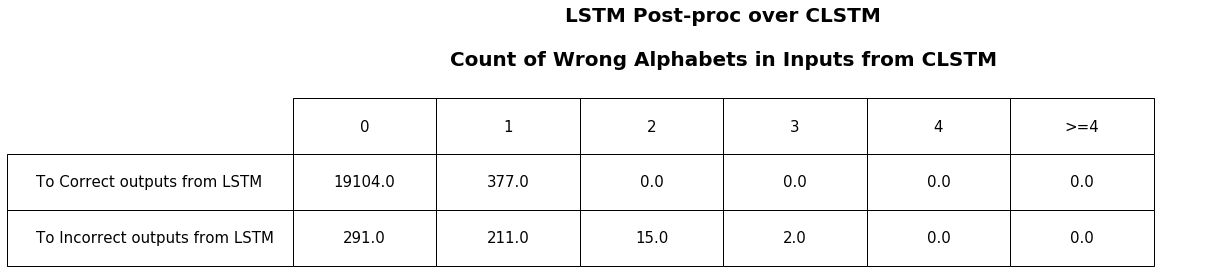

In [16]:
plot_post_processor_stats(postproc_stats[4], model_name=model_names[4])

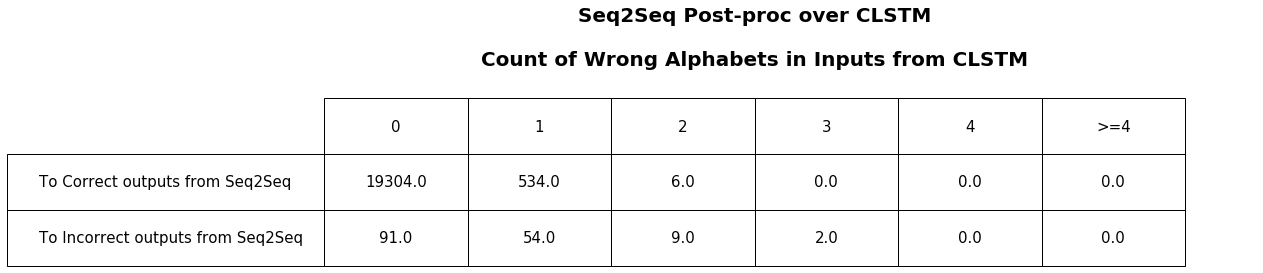

In [17]:
plot_post_processor_stats(postproc_stats[5], model_name=model_names[5])

## Distortion Test

Let's make this analysis more interesting! We are dealing with only static images for this project. However, if we were to
imagine that the input sequences of gestures came from a video or live demonstration, which is more practical, it is quite
likely that some distorted images may be sampled due to continuous motion.

Here, we define a function that can perform SHEARING operation on 1 or more images from a chosen sequence. 

The sequence index is given as first argument and the desired number of distortions as second argumnet. 

The distortions are applied on random positions in a sequence.

In [23]:
def run(dat, temp_label):
    
    CNN_spellings,  mismatch_cnt, err = BasicCNN_evaluation(dat, temp_label, Cnet)

    pred = ''.join([alphas[x] for x in CNN_spellings[0]])
    print('\nCNN output\t: ', pred)

    LSTMoverCNN_spellings,  mismatch_cnt, err, in_out_stats = LSTM_PostProc_evaluation(CNN_spellings, labels, lstm)
    
    pred = ''.join([alphas[x] for x in LSTMoverCNN_spellings[0]])
    print('\nLSTM over CNN output\t: ', pred)
    
    Seq2SeqOverCNN_spellings, mismatch_cnt, err, in_out_stats = Seq2Seq_PostProc_evaluation(CNN_spellings, temp_label, 
                                                                                                                   encoder, decoder)

    pred = ''.join([alphas[x] for x in Seq2SeqOverCNN_spellings[0]])
    print('\nSeq2Seq over CNN output\t: ', pred)

    
    
    CLSTM_spellings,  mismatch_cnt, err = CLSTM_evaluation(dat, temp_label, clstm)

    pred = ''.join([alphas[x] for x in CLSTM_spellings[0]])
    print('\n\nCLSTM output: ', pred)

    
    LSTMoverCNN_spellings,  mismatch_cnt, err, in_out_stats = LSTM_PostProc_evaluation(CLSTM_spellings, labels, lstm)
    
    pred = ''.join([alphas[x] for x in LSTMoverCNN_spellings[0]])
    print('\nLSTM over CLSTM output\t: ', pred)
    
    
    Seq2SeqOverCLSTM_spellings,mismatch_cnt,err,in_out_stats = Seq2Seq_PostProc_evaluation(CLSTM_spellings, temp_label, 
                                                                                                   encoder, decoder)

    pred = ''.join([alphas[x] for x in Seq2SeqOverCLSTM_spellings[0]])
    print('\nSeq2Seq over CLSTM output: ', pred)

Original Word:  abbrieviated


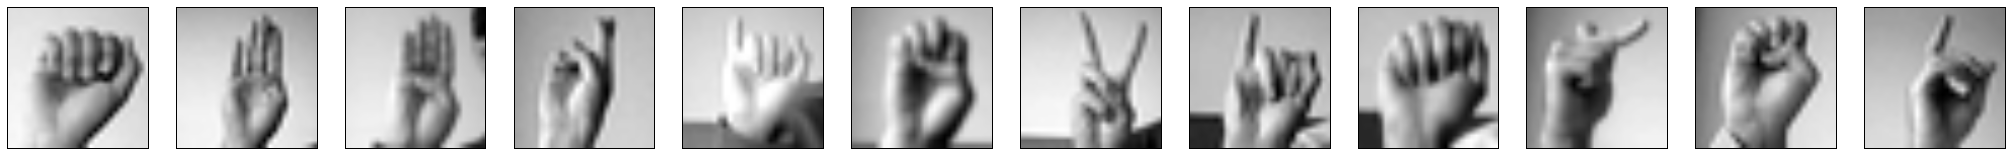


Distorted Sequence


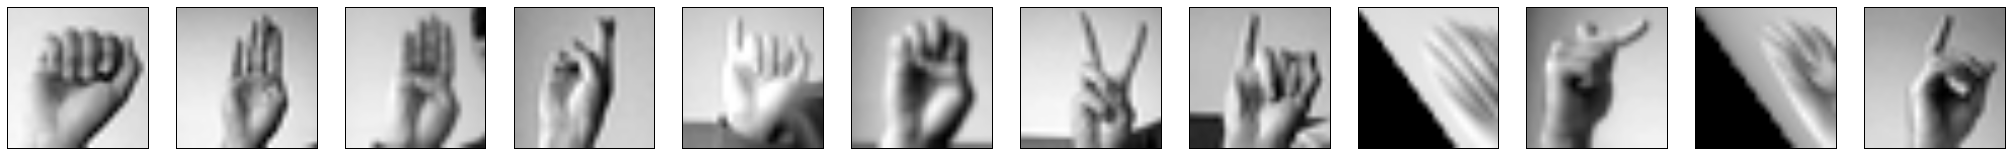


CNN output	:  abbuieviptpd

LSTM over CNN output	:  arbridviated

Seq2Seq over CNN output	:  abbrieviated


CLSTM output:  abbrieviotid

LSTM over CLSTM output	:  abbrievitted

Seq2Seq over CLSTM output:  abberieviati


In [40]:
dat, temp_label = distortion_test(230, 2, testWordstestImages, data)

run(dat, temp_label)


Original Word:  abbrieviated


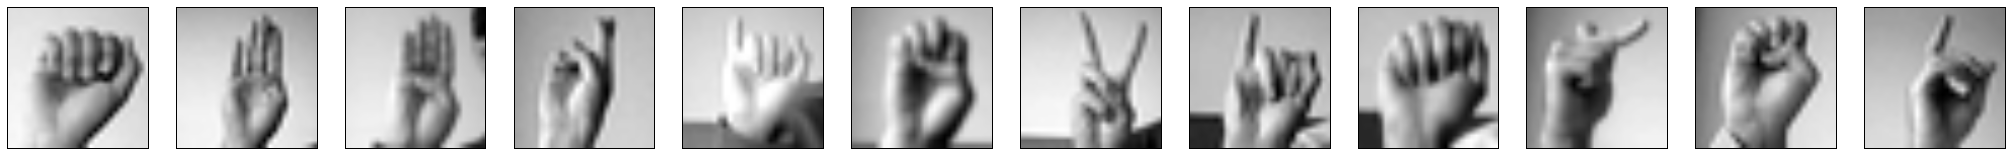


Distorted Sequence


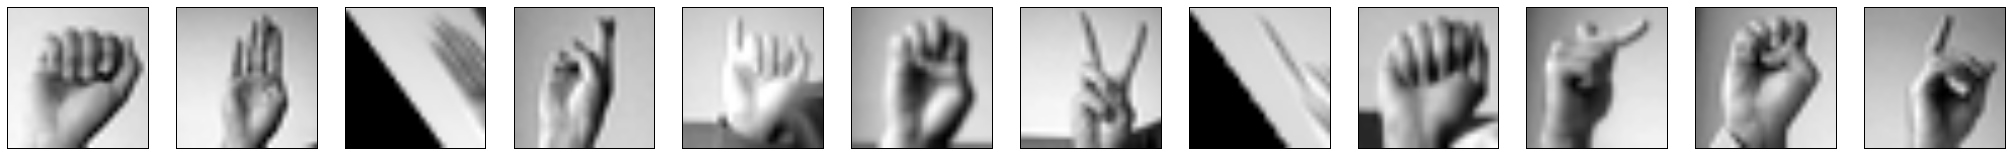


CNN output	:  abvuievpated

LSTM over CNN output	:  absrieviated

Seq2Seq over CNN output	:  abbrieviated


CLSTM output:  abbrieviated

LSTM over CLSTM output	:  abbrieviated

Seq2Seq over CLSTM output:  abbrieviated


In [41]:
dat, temp_label = distortion_test(230, 2, testWordstestImages, data)

run(dat, temp_label)


Original Word:  abbrieviated


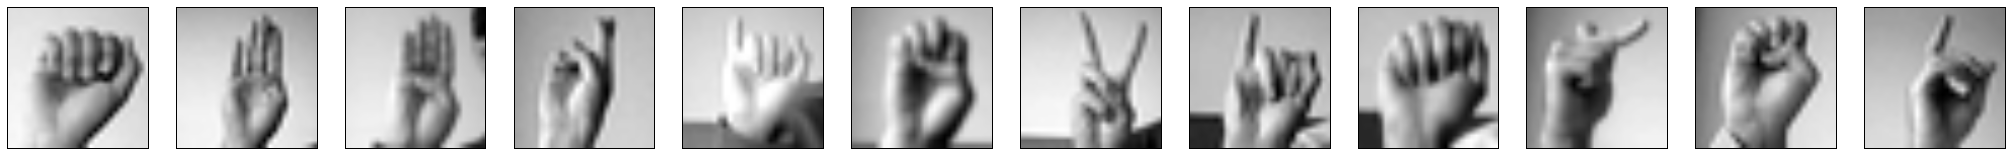


Distorted Sequence


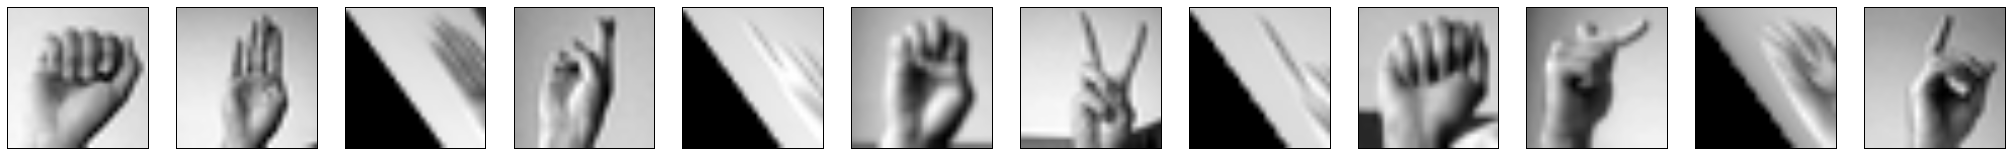


CNN output	:  abvuvevpatpd

LSTM over CNN output	:  abrrrevpated

Seq2Seq over CNN output	:  ackvitedddon


CLSTM output:  abbrieviatid

LSTM over CLSTM output	:  abbrieviated

Seq2Seq over CLSTM output:  abbrieviated


In [35]:
dat, temp_label = distortion_test(230, 4, testWordstestImages, data)

run(dat, temp_label)


Original Word:  abbrieviated


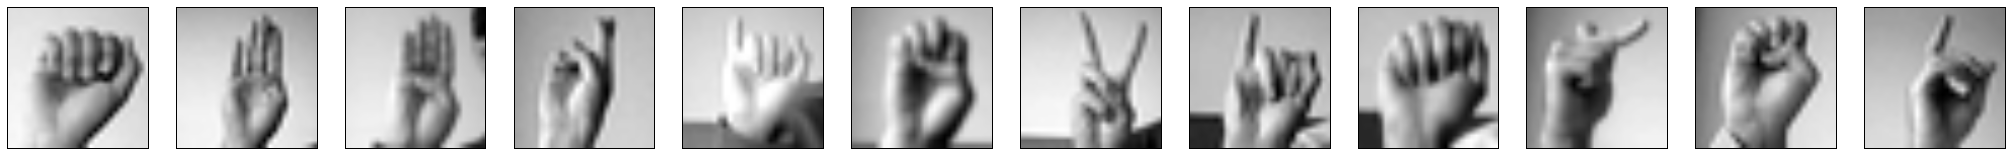


Distorted Sequence


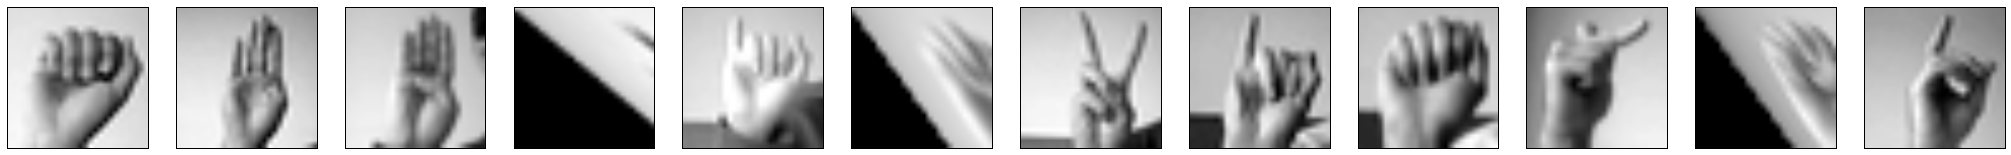


CNN output	:  abbpipviatpd

LSTM over CNN output	:  abbripviated

Seq2Seq over CNN output	:  abbriviatedd


CLSTM output:  abbpivviatid

LSTM over CLSTM output	:  abrrivviatid

Seq2Seq over CLSTM output:  abbriviatedd


In [36]:
dat, temp_label = distortion_test(230, 4, testWordstestImages, data)

run(dat, temp_label)